## **Simulando o Feixe**

Esse trabalho tem como objetivo simular o comportamento de um feixe de elétrons em acelerador linear, bem como a sua correção utilizando eletroímãs corretores.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12 
})

Equações principais:

$$
\vec{F} = m \cdot \vec{a} = \frac{d\vec{p}}{dt}
$$

$$
\gamma = \sqrt{1 + \left(\frac{|\vec{v}|}{c} \right)^2} = \sqrt{1 + \left(\frac{|\vec{p}|}{m_0 c}\right)^2}
$$

$$
\vec{v} = \frac{\vec{v}}{\gamma} = \frac{\vec{p}}{m_0 \gamma} \approx c
$$

<!-- $$
\vec{v} = v_x \hat{i} + v_y \hat{j} + v_z \hat{k} \rightarrow |\vec{v}| = \sqrt{v_x^2 + v_y^2 + v_z^2} \approx c
$$ -->

$$
\vec{B} = B_x \hat{i} + B_y \hat{j} + B_z \hat{k}
$$

$$
\vec{F}^{N+1} = \vec{F}^{N} + \vec{f}_{ext} \cdot \Delta t = \vec{F}^{N} + q \cdot \vec{v} \times \vec{B} \cdot \Delta t
$$

In [2]:
np.random.seed(404)

config = {
    "V_LUZ": 2.99792458e8, # m\s
    "MASSA_E": 9.1093837e-31, # kg
    "CARGA_E": - 1.60217663e-19, # C
    "HEIGHT": 100,
    "WIDTH": 100,
}

parametros = {
    "vx0": 0.0,
    "vy0": 0.0,
    "vz0": 0.999999 * config["V_LUZ"],
    "x0": 0,
    "y0": 0,
    "z0": 0.0,
    "forca": [0, 0, 0],
    "int_ruido": 0.008,
    "grad_mag": 5.0,
    "delay": 10e-9,   
    "dt": 1e-12,
    "dist": 3,
}       

In [3]:
class FeixeEletron():
    def __init__(self, parametros, config):
        self.c = config["V_LUZ"]
        self.m_e = config["MASSA_E"]
        self.q_e = config["CARGA_E"]
        self.dt = parametros["dt"]
        self.int_ruido = parametros["int_ruido"]

        self.gradiente_magnetico = parametros["grad_mag"]
        self.delay = parametros["delay"]

        self.centro_x = parametros["x0"]
        self.centro_y = parametros["y0"]

        self.forca = np.array(parametros["forca"], dtype=float)
        self.pos0 = np.array([parametros["x0"], parametros["y0"], parametros["z0"]], dtype=float)
        self.vel0 = np.array([parametros["vx0"], parametros["vy0"], parametros["vz0"]], dtype=float)

        v0_mag = np.linalg.norm(self.vel0)
        self.gamma0 = 1.0 / np.sqrt(1.0 - (v0_mag/self.c)**2)
        self.momento0 = self.m_e * self.vel0 * self.gamma0

    def momento_para_velocidade(self, momento):
        momento_norm = np.linalg.norm(momento)
        gamma = np.sqrt(1 + ((momento_norm)/(self.m_e * self.c))**2)

        velocidade = momento / (gamma * self.m_e)

        return velocidade
    
    def aplicar_ruido(self, vetor, intensidade_max):
        # theta_x, theta_y, theta_z = np.random.uniform(-intensidade_max, intensidade_max, 3)
        theta_x, theta_y, theta_z = np.random.normal(0, (self.int_ruido)**2, 3)
        
        Rx = np.array([[1, 0, 0], [0, np.cos(theta_x), -np.sin(theta_x)], [0, np.sin(theta_x), np.cos(theta_x)]])
        
        Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)], [0, 1, 0], [-np.sin(theta_y), 0, np.cos(theta_y)]])
        
        vetor_rotacionado = Ry @ (Rx @ vetor)
        
        return vetor_rotacionado

    def calcular_campo_B(self, posicao):
        
        dx = posicao[0] - self.centro_x
        dy = posicao[1] - self.centro_y
        
        Bx = self.gradiente_magnetico * dy
        By = -self.gradiente_magnetico * dx
        Bz = 0

        return np.array([Bx, By, Bz])
    
    def calcular_forca_lorentz(self, velocidade, campo_B):
        carga = self.q_e
        return carga * np.cross(velocidade, campo_B)


    def runge_kutta(self, n_times):
        self.pos = np.zeros((n_times + 1, 3))
        self.dx = np.zeros((n_times + 1))
        self.dy = np.zeros((n_times + 1))

        self.vel = np.zeros((n_times + 1, 3))
        self.momentos = np.zeros((n_times + 1, 3))
        self.t = np.zeros(n_times + 1)

        self.pos[0] = self.pos0
        self.vel[0] = self.vel0

        momento_atual = self.momento0
        pos_atual = self.pos0
    
        for i in range(n_times):
            # k1
            momento_k1 = momento_atual
            v_k1 = self.momento_para_velocidade(momento_k1) 

            pos_k1 = pos_atual
            B_k1 = self.calcular_campo_B(pos_k1)     
            forca_k1 = self.calcular_forca_lorentz(v_k1, B_k1) + self.forca

            # k2
            momento_k2 = momento_atual + 0.5 * self.dt * forca_k1 
            v_k2 = self.momento_para_velocidade(momento_k2)

            pos_k2 = pos_atual + 0.5 * self.dt * v_k1
            B_k2 = self.calcular_campo_B(pos_k2)
            forca_k2 = self.calcular_forca_lorentz(v_k2, B_k2)

            # k3
            momento_k3 = momento_atual + 0.5 * self.dt * forca_k2
            v_k3 = self.momento_para_velocidade(momento_k3)

            pos_k3 = pos_atual + 0.5 * self.dt * v_k2
            B_k3 = self.calcular_campo_B(pos_k3)
            forca_k3 = self.calcular_forca_lorentz(v_k3, B_k3) + self.forca

            # k4
            momento_k4 = momento_atual + self.dt * forca_k3
            v_k4 = self.momento_para_velocidade(momento_k4)

            pos_k4 = pos_atual + self.dt * v_k3
            B_k4 = self.calcular_campo_B(pos_k4)
            forca_k4 = self.calcular_forca_lorentz(v_k4, B_k4) + self.forca

            # somando
            momento_atual += (self.dt / 6) * (forca_k1 + 2*forca_k2 + 2*forca_k3 + forca_k4)
            pos_atual += (self.dt / 6) * (v_k1 + 2*v_k2 + 2*v_k3 + v_k4)

            momento_atual = self.aplicar_ruido(momento_atual, self.int_ruido)
            
            self.momentos[i+1] = momento_atual
            self.vel[i+1] = self.momento_para_velocidade(momento_atual)
            self.pos[i+1] = pos_atual
            self.t[i+1] = (i+1) * self.dt  

distancia = parametros["dist"]
segundos = distancia / config["V_LUZ"]
N_PASSOS = int(segundos / parametros["dt"])

eletron = FeixeEletron(parametros, config)
eletron.runge_kutta(N_PASSOS)
eletron.vel[0:10]

array([[ 0.00000000e+00,  0.00000000e+00,  2.99792158e+08],
       [ 2.56614729e+04,  2.26919331e+04,  2.99792156e+08],
       [ 2.16457051e+04,  1.20117857e+04,  2.99792157e+08],
       [ 2.08126254e+04, -1.16825201e+04,  2.99792157e+08],
       [ 4.65984587e+04, -3.47198451e+04,  2.99792153e+08],
       [ 7.85596078e+04, -5.45972218e+04,  2.99792143e+08],
       [ 8.61283334e+04, -7.50695957e+04,  2.99792136e+08],
       [ 6.76227491e+04, -4.91041143e+04,  2.99792147e+08],
       [ 4.83161823e+04, -5.52658124e+04,  2.99792149e+08],
       [ 5.18051314e+04, -5.58475429e+04,  2.99792149e+08]])

### **Gráficos da simulação**

#### **Gráfico da Velocidade**

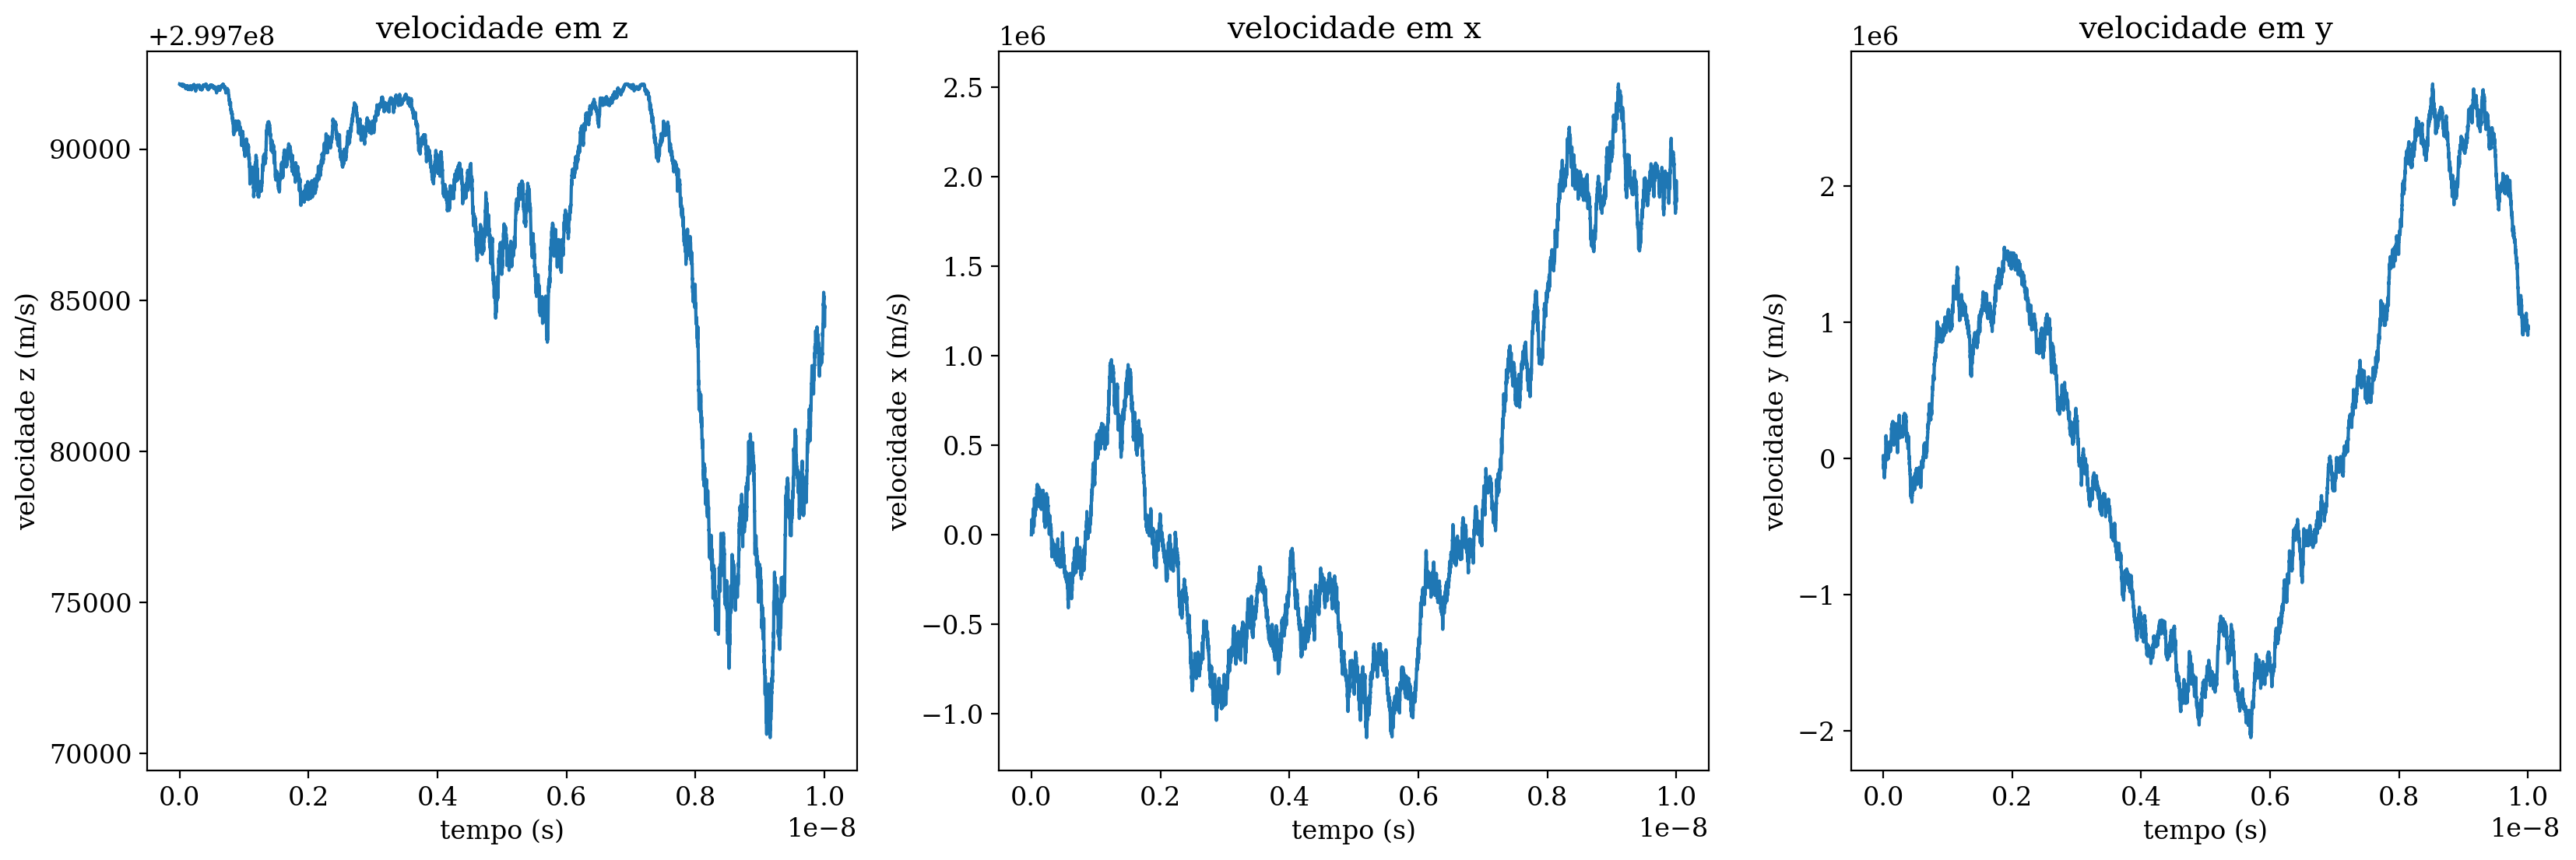

In [4]:
tempo = eletron.t
velocidade_x = eletron.vel[:, 0]
velocidade_y = eletron.vel[:, 1]
velocidade_z = eletron.vel[:, 2]
posicao = eletron.pos[:, 2]


fig = plt.figure(figsize=(20, 6), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempo, velocidade_z)
ax1.set_ylabel("velocidade z (m/s)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("velocidade em z")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempo, velocidade_x)
ax3.set_ylabel("velocidade x (m/s)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("velocidade em x")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempo, velocidade_y)
ax4.set_ylabel("velocidade y (m/s)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("velocidade em y")

plt.show()


<!-- - Delay: Olhar para a posição do elétron $N$ passos atrás no tempo. (~150 nanosegundos)

- Controle: Com base no desvio detectado no passado, ajustamos a corrente (o Gradiente $G$) do eletroímã.

- Força de Lorentz: Aplicamos a força magnética baseada nesse gradiente na posição atual do elétron. O campo de um quadripolo ideal é geralmente $\vec{B} = G \cdot (y \hat{i} + x \hat{j}, 0)$. -->

#### **Gráfico da Posição**

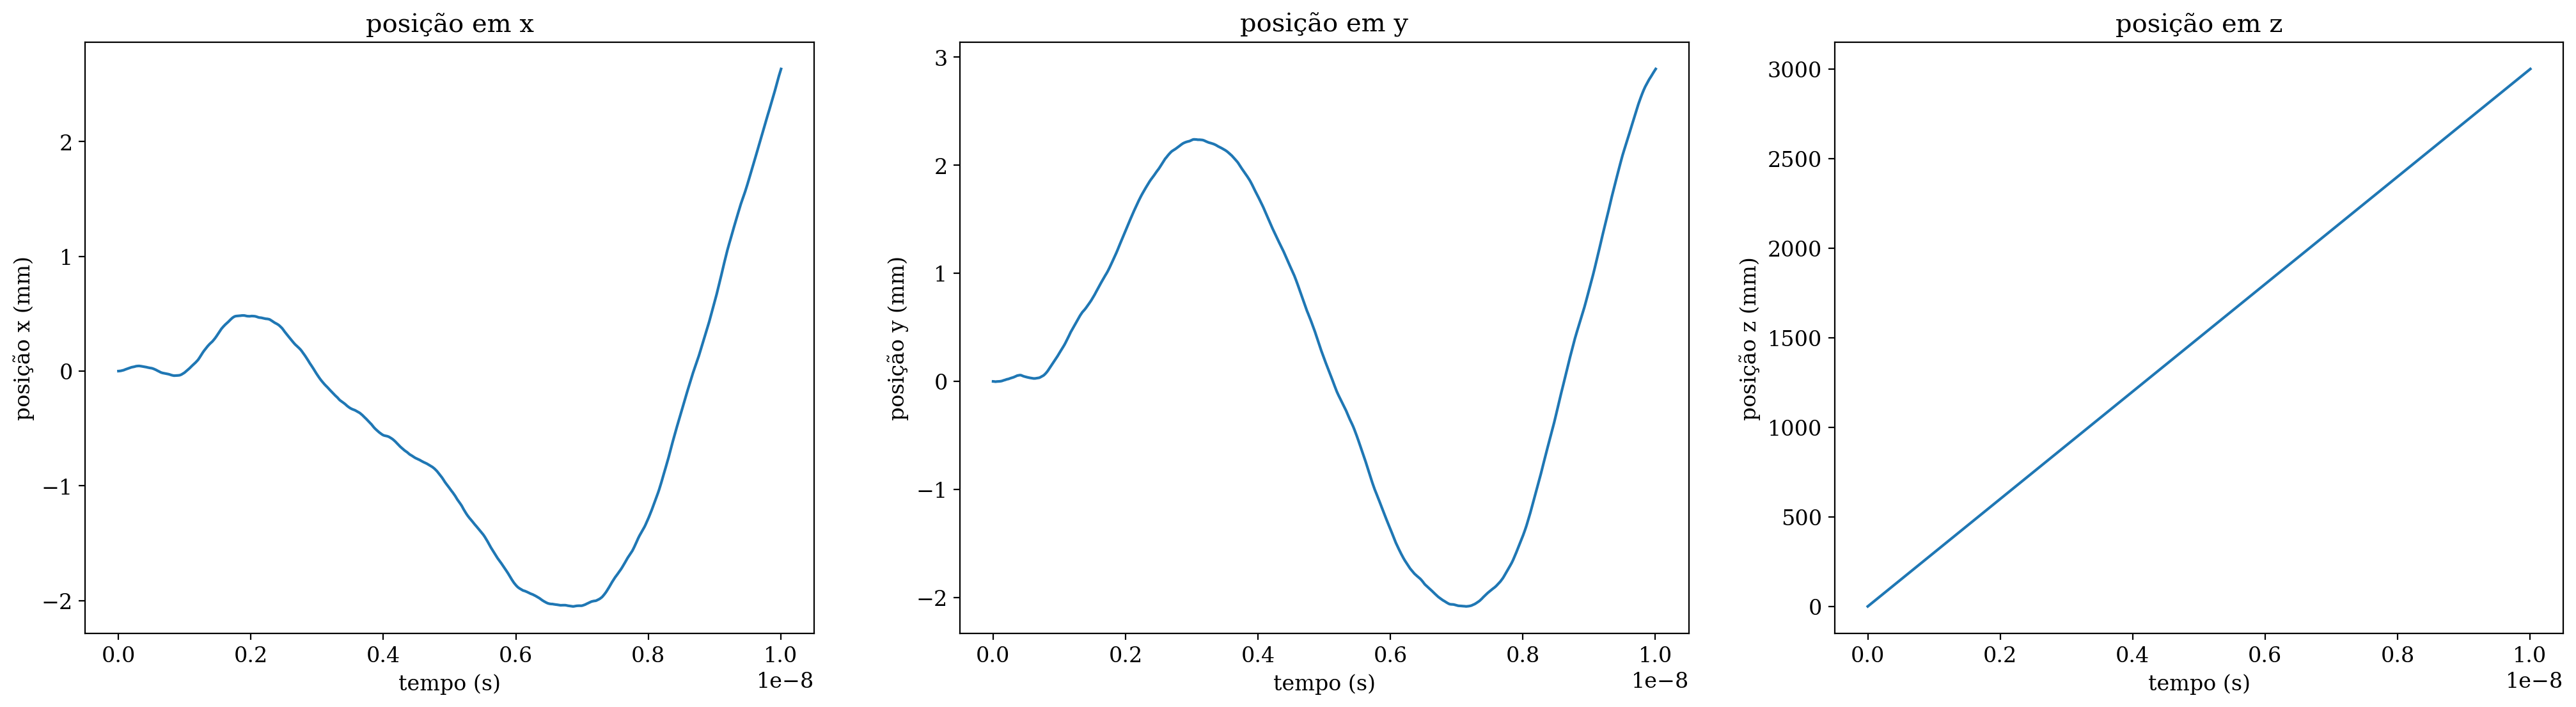

In [5]:
tempo = eletron.t
velocidade_x = eletron.vel[:, 0]
velocidade_y = eletron.vel[:, 1]
velocidade_z = eletron.vel[:, 2]
posicao_x = eletron.pos[:, 0]
posicao_y = eletron.pos[:, 1]
posicao_z = eletron.pos[:,   2]
desvio_x = posicao_x - parametros["x0"]

fig = plt.figure(figsize=(25, 6), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempo, posicao_x * 1000)
ax1.set_ylabel("posição x (mm)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("posição em x")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempo, posicao_y * 1000)
ax3.set_ylabel("posição y (mm)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("posição em y")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempo, posicao_z * 1000)
ax4.set_ylabel("posição z (mm)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("posição em z")

plt.show()

In [6]:
posicao_x = eletron.pos[:, 0]
desvios = abs(posicao_x - parametros["x0"])

print(max(posicao_x))
print(min(posicao_x))
print(f"O desvio máximo foi de {max(desvios)} metros")

0.0026327971593819413
-0.0020505538676070614
O desvio máximo foi de 0.0026327971593819413 metros


#### **Gráfico com a Compração das Trajetórias com e sem Correção**

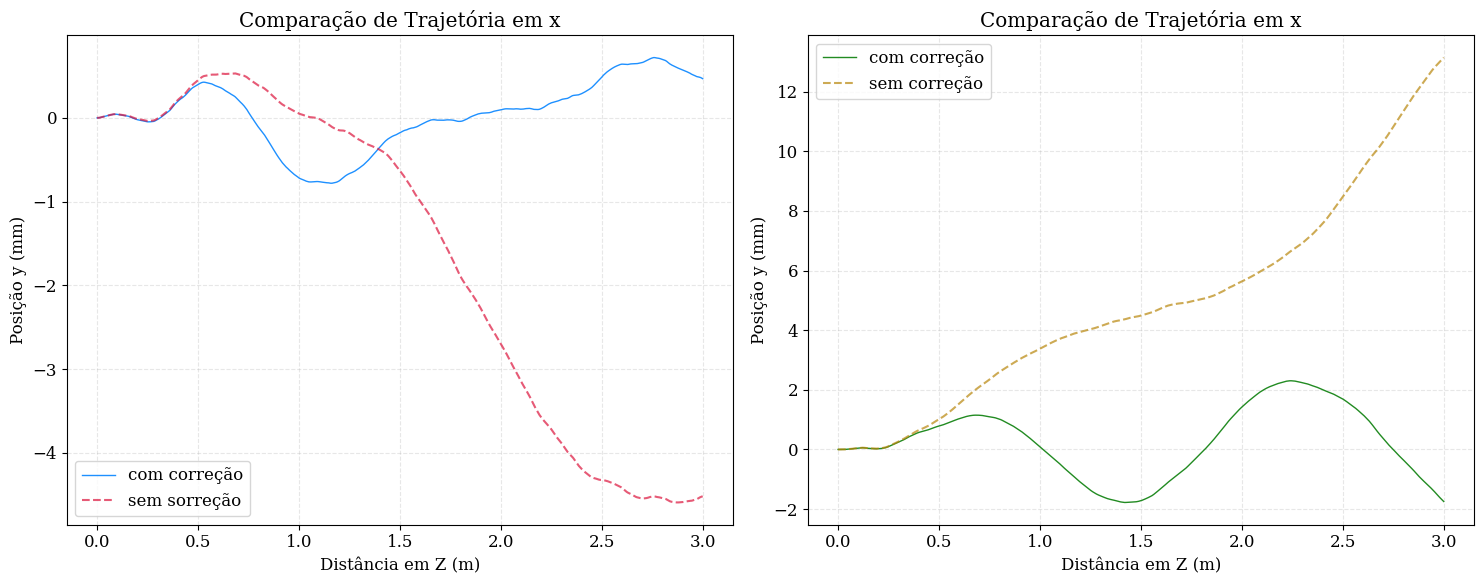

Desvio máximo em x (com correção): 0.7802926022597675 mm
Desvio máximo em x (sem correção): 4.591324014309118 mm

Desvio máximo em y (com correção): 2.3043804142432345 mm
Desvio máximo em y (sem correção): 13.145667226101896 mm


In [7]:
params_com_correcao = parametros.copy()
params_com_correcao["grad_mag"] = 20

params_sem_correcao = parametros.copy()
params_sem_correcao["grad_mag"] = 0

np.random.seed(404) 
simulacao_com = FeixeEletron(params_com_correcao, config)
simulacao_com.runge_kutta(N_PASSOS)

np.random.seed(404)
simulacao_sem = FeixeEletron(params_sem_correcao, config)
simulacao_sem.runge_kutta(N_PASSOS)

fig = plt.figure(figsize=(15, 6), dpi=100)
gs = gridspec.GridSpec(1, 2, figure=fig)

z_com = simulacao_com.pos[:, 2]
x_com = simulacao_com.pos[:, 0] * 1000
y_com = simulacao_com.pos[:, 1] * 1000

z_sem = simulacao_sem.pos[:, 2]
x_sem = simulacao_sem.pos[:, 0] * 1000
y_sem = simulacao_sem.pos[:, 1] * 1000

# desvio em x
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(z_com, x_com, label="com correção", color="dodgerblue", linewidth=1)
ax1.plot(z_sem, x_sem, label="sem sorreção", color="crimson", linestyle="--", alpha=0.7)
ax1.set_ylabel("Posição y (mm)")
ax1.set_xlabel("Distância em Z (m)")
ax1.set_title("Comparação de Trajetória em x")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.3)

# desvio em y
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(z_com, y_com, label="com correção", color="forestgreen", linewidth=1)
ax2.plot(z_sem, y_sem, label="sem correção", color="darkgoldenrod", linestyle="--", alpha=0.7)
ax2.set_ylabel("Posição y (mm)")
ax2.set_xlabel("Distância em Z (m)")
ax2.set_title("Comparação de Trajetória em x")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Desvio máximo em x (com correção): {np.max(abs(x_com))} mm")
print(f"Desvio máximo em x (sem correção): {np.max(abs(x_sem))} mm")

print(f"\nDesvio máximo em y (com correção): {np.max(abs(y_com))} mm")
print(f"Desvio máximo em y (sem correção): {np.max(abs(y_sem))} mm")

### **Animação da Simulação**

In [8]:
# from matplotlib.animation import FuncAnimation
# from matplotlib.patches import Circle
# from matplotlib.widgets import Slider

# %matplotlib widget

# anim = None  

# try:
#     anim.event_source.stop()
# except AttributeError:
#     pass
# plt.close("all")

# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# fig.canvas.header_visible = False  

# gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[0.4, 0.4, 0.2])

# ax.set_xlim(parametros["x0"]-12, parametros["x0"]+12)
# ax.set_ylim(parametros["y0"]-12, parametros["y0"]+12)
# ax.set_ylabel("Posição Y (mm)")
# ax.set_xlabel("Posição X (mm)")
# ax.set_title(f"Simulação do Feixe")
# ax.set_aspect("equal") 
# ax.grid(True, alpha=0.05)

# time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

# pos_x_inicial_mm = parametros["x0"] * 1000
# pos_y_inicial_mm = parametros["y0"] * 1000

# fig_eletron = ax.scatter(pos_x_inicial_mm, pos_y_inicial_mm, color="blue")
# fig_anel = Circle((parametros["x0"], parametros["y0"]), radius=10, fill=False, color="r")
# ax.add_patch(fig_anel)

# def animate(frame):
#     pos_x_atual = eletron.pos[frame, 0] * 1000
#     pos_y_atual = eletron.pos[frame, 1] * 1000
#     pos_z_atual = eletron.pos[frame, 2]

#     fig_eletron.set_offsets(np.array([[pos_x_atual, pos_y_atual]]))

#     tempo_atual = eletron.t[frame]
#     time_text.set_text(f"Passo: {frame} | Tempo: {tempo_atual:.12f}s | Distancia: {pos_z_atual:.6f}m")

#     return fig_eletron, time_text

# anim = FuncAnimation(fig, animate, frames=range(0, N_PASSOS, 10), interval=30, blit=True, repeat=False)
# plt.show()

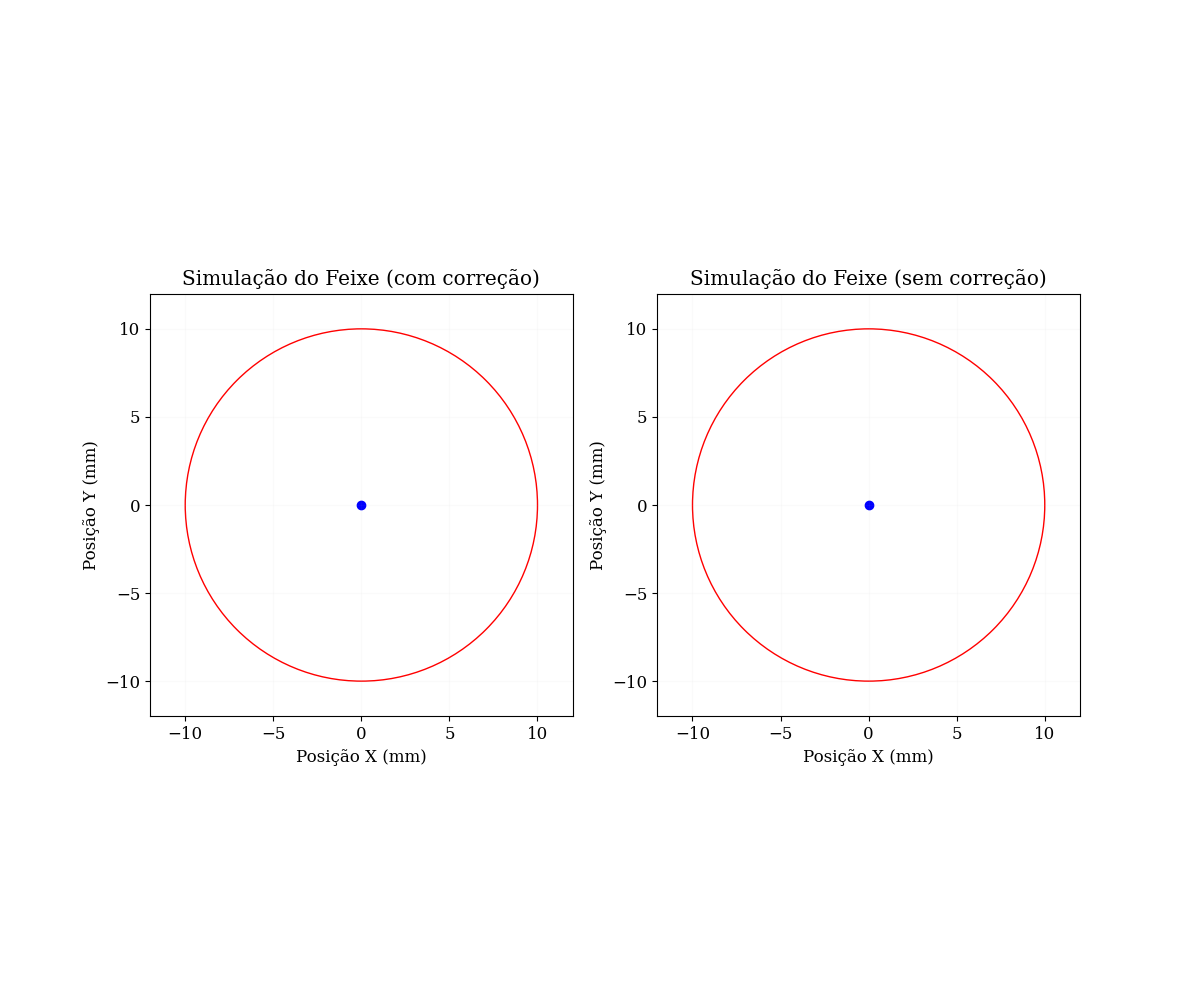

In [10]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
from matplotlib.widgets import Slider

%matplotlib widget

anim = None  

try:
    anim.event_source.stop()
except AttributeError:
    pass
plt.close("all")

fig = plt.figure(figsize=(12, 10))
fig.canvas.header_visible = False  

gs = gridspec.GridSpec(1, 2, figure=fig, height_ratios=[1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlim(parametros["x0"]-12, parametros["x0"]+12)
ax1.set_ylim(parametros["y0"]-12, parametros["y0"]+12)
ax1.set_ylabel("Posição Y (mm)")
ax1.set_xlabel("Posição X (mm)")
ax1.set_title(f"Simulação do Feixe (com correção)")
ax1.set_aspect("equal") 
ax1.grid(True, alpha=0.05)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlim(parametros["x0"]-12, parametros["x0"]+12)
ax2.set_ylim(parametros["y0"]-12, parametros["y0"]+12)
ax2.set_ylabel("Posição Y (mm)")
ax2.set_xlabel("Posição X (mm)")
ax2.set_title(f"Simulação do Feixe (sem correção)")
ax2.set_aspect("equal") 
ax2.grid(True, alpha=0.05)

time_text = fig.text(0.02, 1.10, "", transform=ax1.transAxes, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

pos_x_inicial_mm = parametros["x0"] * 1000
pos_y_inicial_mm = parametros["y0"] * 1000

fig_eletron_com = ax1.scatter(pos_x_inicial_mm, pos_y_inicial_mm, color="blue")
fig_eletron_sem = ax2.scatter(pos_x_inicial_mm, pos_y_inicial_mm, color="blue")
fig_anel_com = Circle((parametros["x0"], parametros["y0"]), radius=10, fill=False, color="r")
fig_anel_sem = Circle((parametros["x0"], parametros["y0"]), radius=10, fill=False, color="r")

ax1.add_patch(fig_anel_com)
ax2.add_patch(fig_anel_sem)

def animate(frame):
    pos_x_com = simulacao_com.pos[frame, 0] * 1000
    pos_y_com = simulacao_com.pos[frame, 1] * 1000
    pos_z_com = simulacao_com.pos[frame, 2]

    pos_x_sem = simulacao_sem.pos[frame, 0] * 1000
    pos_y_sem = simulacao_sem.pos[frame, 1] * 1000
    pos_z_sem = simulacao_sem.pos[frame, 2]

    fig_eletron_com.set_offsets(np.array([[pos_x_com, pos_y_com]]))
    fig_eletron_sem.set_offsets(np.array([[pos_x_sem, pos_y_sem]]))

    tempo_atual = simulacao_com.t[frame]
    time_text.set_text(f"Passo: {frame} | Tempo: {tempo_atual:.12f}s")

    return fig_eletron_com, fig_eletron_sem, time_text

anim = FuncAnimation(fig, animate, frames=range(0, N_PASSOS, 10), interval=30, blit=True, repeat=False)
plt.show()